In [1]:
# 全卷积网络
''' 
如 13.9节中所介绍的那样，语义分割是对图像中的每个像素分类。全卷积⽹络（fully convolutional network，
FCN）采⽤卷积神经⽹络实现了从图像像素到像素类别的变换 [Long et al., 2015]。与我们之前在图像分类或
⽬标检测部分介绍的卷积神经⽹络不同，全卷积⽹络将中间层特征图的⾼和宽变换回输⼊图像的尺⼨：这是
通过在 13.10节中引⼊的转置卷积（transposed convolution）实现的。因此，输出的类别预测与输⼊图像在
像素级别上具有⼀⼀对应关系：通道维的输出即该位置对应像素的类别预测
'''
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# 构造模型
'''
下 ⾯， 我 们 使 ⽤ 在ImageNet数 据 集 上 预 训 练 的ResNet-18模 型 来 提 取 图 像 特 征， 并 将 该 ⽹ 络 记
为pretrained_net。ResNet-18模型的最后⼏层包括全局平均汇聚层和全连接层，然⽽全卷积⽹络
中不需要它们
'''
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:] #显示后三层

/home/ubuntu/anaconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
''' 
接下来，我们创建⼀个全卷积⽹络net。它复制了ResNet-18中⼤部分的预训练层，除了最后的全局平均汇聚
层和最接近输出的全连接层
'''
# Sequential 中添加不包含最后两层的resnet18
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
'给定⾼度为320和宽度为480的输⼊，net的前向传播将输⼊的⾼和宽减⼩⾄原来的1/32，即10和15'
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [5]:
''' 
接下来，我们使⽤1 × 1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。最后，我们需要将
特征图的⾼度和宽度增加32倍，从⽽将其变回输⼊图像的⾼和宽。回想⼀下 6.3节中卷积层输出形状的计算
⽅法：由于(320 − 64 + 16 × 2 + 32)/32 = 10且(480 − 64 + 16 × 2 + 32)/32 = 15，我们构造⼀个步幅为32的
转置卷积层，并将卷积核的⾼和宽设为64，填充为16。我们可以看到如果步幅为s，填充为s/2（假设s/2是整
数）且卷积核的⾼和宽为2s，转置卷积核会将输⼊的⾼和宽分别放⼤s倍
'''
num_classes = 21 # 通道数与类别数对应
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1)) # 使用1×1卷积将512通道变为21
# 通道数不变,使用大小为64x64,填充16,步幅32的转置卷积核使其恢复为原图尺寸
# 若步幅为s，填充为s/2,且卷积核的⾼和宽为2s，则转置卷积核会将输⼊的⾼和宽分别放⼤s倍
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                                    kernel_size=64, padding=16, stride=32))

In [6]:
# 初始化转置转置卷积层
''' 
在图像处理中，我们有时需要将图像放⼤，即上采样（upsampling）。双线性插值（bilinear interpolation）
是常⽤的上采样⽅法之⼀，它也经常⽤于初始化转置卷积层。
为了解释双线性插值，假设给定输⼊图像，我们想要计算上采样输出图像上的每个像素。⾸先，将输出图像
的坐标(x, y)映射到输⼊图像的坐标(x′, y′)上。例如，根据输⼊与输出的尺⼨之⽐来映射。请注意，映射后
的x′和y′是实数。然后，在输⼊图像上找到离坐标(x′, y′)最近的4个像素。最后，输出图像在坐标(x, y)上的像
素依据输⼊图像上这4个像素及其与(x′, y′)的相对距离来计算。
双线性插值的上采样可以通过转置卷积层实现，内核由以下bilinear_kernel函数构造。限于篇幅，我们
只给出bilinear_kernel函数的实现，不讨论算法的原理
'''
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
        (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [7]:
'''
让我们⽤双线性插值的上采样实验它由转置卷积层实现。我们构造⼀个将输⼊的⾼和宽放⼤2倍的转置卷积
层，并将其卷积核⽤bilinear_kernel函数初始化
'''
# 放大两倍的转置卷积层
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,bias=False)
# 卷积核使用双线性插值进行初始化
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [8]:
'读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置'
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0) # 增加维度为四维输入
Y = conv_trans(X) # 转置卷积
out_img = Y[0].permute(1, 2, 0).detach() # 调整通道位置CxHxW -> HxWxC

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


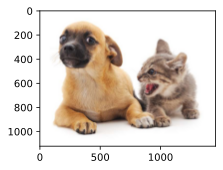

In [9]:
''' 
可以看到，转置卷积层将图像的⾼和宽分别放⼤了2倍。除了坐标刻度不同，双线性插值放⼤的图像和在
13.3节中打印出的原图看上去没什么两样
'''
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape) # 输入图像形状
d2l.plt.imshow(img.permute(1, 2, 0)); # 打印
print('output image shape:', out_img.shape) # 输出图像形状
d2l.plt.imshow(out_img); # 打印

In [10]:
''' 
在全卷积⽹络中，我们⽤双线性插值的上采样初始化转置卷积层。对于1 × 1卷积层，我们使⽤Xavier初始化
参数(使得每一层输出的方差应该尽量相等)
'''
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W); # 使用双线性插值初始化转置卷积层

In [11]:
# 读取数据集
''' 
我们⽤ 13.9节中介绍的语义分割读取数据集。指定随机裁剪的输出图像的形状为320 × 480：⾼和宽都可以
被32整除
'''
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size) # 加载voc数据集

read 1114 examples
read 1078 examples


loss 0.413, train acc 0.870, test acc 0.854
137.2 examples/sec on [device(type='cuda', index=0)]


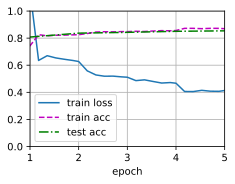

In [12]:
# 训练 
''' 
现在我们可以训练全卷积⽹络了。这⾥的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为
我们使⽤转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。此外，模型基于每个像
素的预测类别是否正确来计算准确率
'''
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
# 训练13章中的模型
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [13]:
# 预测
'在预测时，我们需要将输⼊图像在各个通道做标准化，并转成卷积神经⽹络所需要的四维输⼊格式'
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0) # unsqueeze 增加维度 
    
    'net = nn.Sequential(*list(pretrained_net.children())[:-2])'
    pred = net(X.to(devices[0])).argmax(dim=1) # 预测
    return pred.reshape(pred.shape[1], pred.shape[2])

In [14]:
'为了可视化预测的类别给每个像素，我们将预测类别映射回它们在数据集中的标注颜⾊'
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

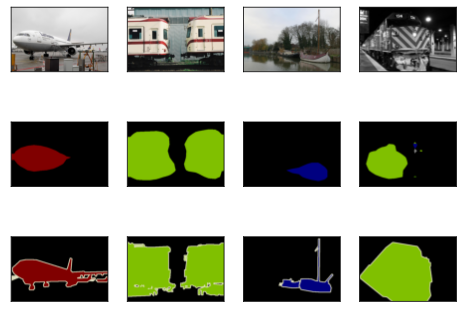

In [16]:
''' 
测试数据集中的图像⼤⼩和形状各异。由于模型使⽤了步幅为32的转置卷积层，因此当输⼊图像的⾼或宽⽆
法被32整除时，转置卷积层输出的⾼或宽会与输⼊图像的尺⼨有偏差。为了解决这个问题，我们可以在图像
中截取多块⾼和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。请注意，这些区域的
并集需要完整覆盖输⼊图像。当⼀个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的
平均值可以作为softmax运算的输⼊，从⽽预测类别。
为简单起⻅，我们只读取⼏张较⼤的测试图像，并从图像的左上⻆开始截取形状为320 × 480的区域⽤于预测。
对于这些测试图像，我们逐⼀打印它们截取的区域，再打印预测结果，最后打印标注的类别
'''
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480) # 剪裁范围
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect) # 剪裁
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2); # 打印截取区域

In [ ]:
''' 
⼩结
• 全卷积⽹络先使⽤卷积神经⽹络抽取图像特征，然后通过1 × 1卷积层将通道数变换为类别个数，最后
通过转置卷积层将特征图的⾼和宽变换为输⼊图像的尺⼨
• 在全卷积⽹络中，我们可以将转置卷积层初始化为双线性插值的上采样
'''